# Translation ecoder-decocer with attention over the b4 dataset

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.ticker as ticker
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
from contra_qa.plots.functions  import simple_step_plot
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu

% matplotlib inline

### Preparing data

In [2]:
df2 = pd.read_csv("data/boolean4_train.csv")
df2_test = pd.read_csv("data/boolean4_test.csv")


df2["text"] = df2["sentence1"] + df2["sentence2"] 
df2_test["text"] = df2_test["sentence1"] + df2_test["sentence2"] 

all_sentences = list(df2.text.values) + list(df2_test.text.values)

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [3]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label,text
8495,Tracy grew up and won the game,Tracy didn't grow up,Tracy grew up,Tracy won the game,1,Tracy grew up and won the gameTracy didn't gro...
8496,Dennis heard Dora and wore a white jacket,Dennis didn't wear a white jacket,Dennis heard Dora,Dennis wore a white jacket,1,Dennis heard Dora and wore a white jacketDenni...
8497,Candice caught a yellow fish and slept the night,Ben didn't sleep the night,Candice caught a yellow fish,Candice slept the night,0,Candice caught a yellow fish and slept the nig...
8498,Anna spent all my money and fought the law,Anna didn't spend all my money,Anna spent all my money,Anna fought the law,1,Anna spent all my money and fought the lawAnna...
8499,Joel sat on the chair and understood what I said,Joel didn't understand what I said,Joel sat on the chair,Joel understood what I said,1,Joel sat on the chair and understood what I sa...


In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "Sheryl went to cluj-Napoca and Hunedoara"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: Sheryl went to cluj-Napoca and Hunedoara

After: sheryl went to cluj napoca and hunedoara


In [6]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [7]:
all_text_pairs = zip(all_sentences, all_sentences)
all_text_pairs = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in all_text_pairs]

In [8]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [9]:
f = lambda x: len(x.split(" "))

MAX_LENGTH = np.max(list(map(f, all_sentences)))

In [10]:
# MAX_LENGTH = 20


def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [11]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [12]:
_, _, training_pairs_A = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_A)
print()


input_lang, _, _ = prepareData("eng_enc",
                               "eng_dec",
                               all_text_pairs)

output_lang = copy.deepcopy(input_lang)

print()

_, _, valid_pairs_A = prepareData("eng_enc",
                                "eng_dec",
                                pairs_A_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 1027
eng_dec 1020

Read 11000 sentence pairs
Trimmed to 10978 sentence pairs
Counting words...
Counted words:
eng_enc 10962
eng_dec 10962

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 979
eng_dec 955


In [13]:
_, _, training_pairs_B = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_B)
print()
_, _, valid_pairs_B = prepareData("eng_enc",
                                "eng_dec",
                                pairs_B_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 1027
eng_dec 1022

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 979
eng_dec 946


In [14]:
# all_sentences_1_and_2 = list(df2.sentence1.values) + list(df2.sentence2.values) + list(df2_test.sentence1.values) + list(df2_test.sentence2.values) 

# f = lambda x: len(x.split(" "))

# MAX_LENGTH = np.max(list(map(f, all_sentences_1_and_2))) + 1

### sentences 2 tensors

In [15]:
example = random.choice(training_pairs_A)
print(example)

('danny spent all my money and was a gentle person', 'danny spent all my money')


In [16]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [17]:
indexesFromSentence(input_lang,example[0])

[2674, 452, 453, 57, 454, 7, 17, 4, 5443, 559]

In [18]:
indexesFromSentence(output_lang, example[1])

[2674, 452, 453, 57, 454]

In [19]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [20]:
input_sen = tensorFromSentence(input_lang,example[0])
output_sen = tensorFromSentence(output_lang, example[1])

print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

tensor([[2674],
        [ 452],
        [ 453],
        [  57],
        [ 454],
        [   7],
        [  17],
        [   4],
        [5443],
        [ 559],
        [   1]])

torch.Size([11, 1])
torch.int64
tensor([[2674],
        [ 452],
        [ 453],
        [  57],
        [ 454],
        [   1]])

torch.Size([6, 1])
torch.int64


In [21]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [22]:
input_sen, output_sen = tensorsFromPair(example)


print("input\n")
print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)

print("\noutput\n")
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

input

tensor([[2674],
        [ 452],
        [ 453],
        [  57],
        [ 454],
        [   7],
        [  17],
        [   4],
        [5443],
        [ 559],
        [   1]])

torch.Size([11, 1])
torch.int64

output

tensor([[2674],
        [ 452],
        [ 453],
        [  57],
        [ 454],
        [   1]])

torch.Size([6, 1])
torch.int64


In [23]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [24]:
hidden_size = 12
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [25]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
h0 = encoder.initHidden()
print("input_sen:", input_sen.shape, input_sen.dtype)
print("h0:", h0.shape, h0.dtype)

input_sen: torch.Size([11, 1]) torch.int64
h0: torch.Size([1, 1, 12]) torch.float32


In [26]:
max_length = MAX_LENGTH
encoder_outputs = torch.zeros(max_length,
                              encoder.hidden_size,
                              device=device)

input_length = input_sen.size(0)

for ei in range(input_length):
    output, hidden_enc = encoder(input_sen[ei], h0)
    h0 = hidden_enc
    encoder_outputs[ei] = output[0, 0]

print("output:", output.shape, output.dtype)
print("hidden_enc:", hidden_enc.shape, hidden_enc.dtype)

output: torch.Size([1, 1, 12]) torch.float32
hidden_enc: torch.Size([1, 1, 12]) torch.float32


In [27]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [28]:
decoder = AttnDecoderRNN(hidden_size, eng_dec_v_size)

decoder_input = torch.tensor([[SOS_token]], device=device)

decoder_hidden = hidden_enc

target_length = output_sen.size(0)

for di in range(target_length):
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
    decoder_input = output_sen[di]  # Teacher forcing
    print("decoder_output:", decoder_output.shape, decoder_output.dtype)
    print()
    print("decoder_hidden:", decoder_hidden.shape, decoder_hidden.dtype)    


decoder_output: torch.Size([1, 10962]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 10962]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 10962]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 10962]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 10962]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 10962]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32


## Calculate loss over each token of the target language

In [29]:
learning_rate = 0.2
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [30]:
def train(input_tensor,
          target_tensor,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          teacher_forcing_ratio=0.2,
          max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [31]:
def get_loss(input_tensor,
             target_tensor,
             encoder,
             decoder,
             criterion,
             max_length):

    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        _, topone = decoder_output.topk(1)
        decoder_input = topone.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break
    return loss.item() / target_length

Test get loss

In [32]:
valid_pairs = [tensorsFromPair(pair) for pair in valid_pairs_A]
valid_loss = []
for t in valid_pairs:
    input_sen, output_sen = t
    loss = get_loss(input_sen,
                    output_sen,
                    encoder,
                    decoder,
                    criterion,
                    MAX_LENGTH)
    valid_loss.append(loss)
print("mean loss", np.mean(valid_loss))

mean loss 9.331914864415973


In [33]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

Test train

0m 13s


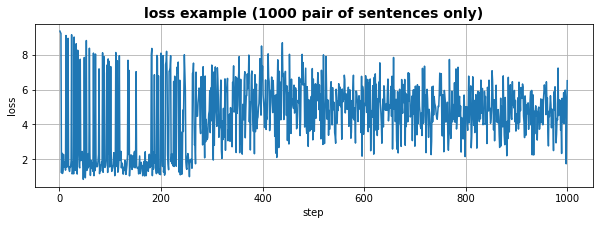

In [34]:
n_iters = 1000
training_pairs_little = [tensorsFromPair(random.choice(training_pairs_A)) for i in range(n_iters)]

losses = []
start = time.time()

for t in training_pairs_little:
    input_sen, output_sen = t    
    loss = train(input_sen,
                 output_sen,
                 encoder,
                 decoder,
                 encoder_optimizer,
                 decoder_optimizer,
                 criterion,
                 max_length=MAX_LENGTH)
    losses.append(loss)

print(timeSince(start))

simple_step_plot([losses],
                 "loss",
                 "loss example ({} pair of sentences only)".format(n_iters),
                 "loss_example.png",
                  figsize=(10,3))

In [35]:
def trainIters(encoder,
               decoder,
               n_iters,
               pairs,
               valid_pairs,
               encoder_path,
               decoder_path,
               batch_size=32,
               status_every=100,
               learning_rate=0.01,
               teacher_forcing_ratio=0.5):

    plot_losses = []
    old = 0
    start = time.time()
    all_loss = []
    valid_loss = float("inf")
    
    

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for i, t in enumerate(training_pairs):
        input_sen, output_sen = t
        loss = train(input_sen,
                     output_sen,
                     encoder,
                     decoder,
                     encoder_optimizer,
                     decoder_optimizer,
                     criterion,
                     max_length=MAX_LENGTH,
                     teacher_forcing_ratio=teacher_forcing_ratio)
        plot_losses.append(loss)

        if i % status_every == 0 and i != 0:
            valid_batch = [tensorsFromPair(random.choice(valid_pairs))
                           for i in range(batch_size)]
            batch_loss = 0
            for t in valid_batch:
                input_sen, output_sen = t
                batch_loss += get_loss(input_sen,
                                       output_sen,
                                       encoder,
                                       decoder,
                                       criterion,
                                       MAX_LENGTH)
            current_valid_loss = batch_loss / batch_size
            
            if current_valid_loss < valid_loss:
                valid_loss = current_valid_loss
                torch.save(encoder.state_dict(), encoder_path)
                torch.save(decoder.state_dict(), decoder_path)
            print("mean training loss = {:.2f}".format(np.mean(plot_losses)))
            print("mean valid loss = {:.2f}".format(current_valid_loss))
            print("time in {} steps:".format(status_every), timeSince(start))
            print()
            all_loss += plot_losses
            plot_losses = []
            old = i
            start = time.time()
    
    simple_step_plot([all_loss],
                     "loss",
                     "loss over training" ,
                     "loss_example.png",
                     figsize=(15, 3))


## translating

In [36]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a non trained model

In [37]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = AttnDecoderRNN(hidden_size, eng_dec_v_size)

np.random.shuffle(training_pairs_A)

In [38]:
for t in training_pairs_A[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()


input_sentence : craig let this happen and hung up on me
neural translation : usgrace usgrace hobbylauren matchaaron crowddaisy raymondelsie meganjerome raymondelsie meganjerome raymondelsie treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil treevirgil
reference translation : craig let this happen <EOS>
blue score = 0.00

input_sentence : judy spoke to her about kenneth and drove the truck to charlie s house
neural translation : housereginald noteleo hobbylauren lyingterry lyingterry lyingterry himdavid gamecarrie crowddaisy gamecarrie yvette crowddaisy yvette yvette yvette yvette mevanessa meganjerome meganjerome lyingterry himdavid raymondelsie yvette yvette yvette mevanessa meganjerome
reference translation : judy spoke to her about kenneth <EOS>
blue score = 0.00

input_sentence : geraldine met him and swam out toward the purple boat
neural translation : smil

## Training some models and observing its translation

In [39]:
def save_translation(pairs, encoder, decoder, max_length, out_path):
    with open(out_path, "w") as file:
        file.write("source,candidate,reference,blue,accuracy\n")        
        for tuple_ in pairs:
            source, reference = tuple_
            candidate = translate(encoder,
                                  decoder,
                                  source,
                                  max_length=max_length)
            reference =  reference + ' <EOS>'
            blue = sentence_bleu([reference.split(" ")], candidate.split(" "))
            if blue >= 0.95:
                acc = 1
            else:
                acc = 0
            line = source + ","
            line += candidate + ","
            line += reference + ","
            line += "{:.3f},".format(blue)
            line += "{}\n".format(acc)
            file.write(line)

Test save_translation

### Training 1

mean training loss = 5.37
mean valid loss = 5.12
time in 1000 steps: 2m 58s

mean training loss = 4.60
mean valid loss = 4.31
time in 1000 steps: 3m 7s

mean training loss = 3.73
mean valid loss = 3.35
time in 1000 steps: 3m 5s

mean training loss = 3.02
mean valid loss = 2.77
time in 1000 steps: 3m 0s

mean training loss = 2.51
mean valid loss = 2.49
time in 1000 steps: 2m 54s

mean training loss = 2.17
mean valid loss = 2.19
time in 1000 steps: 2m 53s

mean training loss = 1.93
mean valid loss = 1.92
time in 1000 steps: 3m 1s

mean training loss = 1.82
mean valid loss = 1.74
time in 1000 steps: 2m 54s

mean training loss = 1.75
mean valid loss = 1.51
time in 1000 steps: 2m 55s

mean training loss = 1.62
mean valid loss = 1.72
time in 1000 steps: 3m 1s

mean training loss = 1.61
mean valid loss = 1.75
time in 1000 steps: 3m 10s

mean training loss = 1.51
mean valid loss = 1.64
time in 1000 steps: 2m 47s

mean training loss = 1.48
mean valid loss = 1.70
time in 1000 steps: 2m 49s

mean

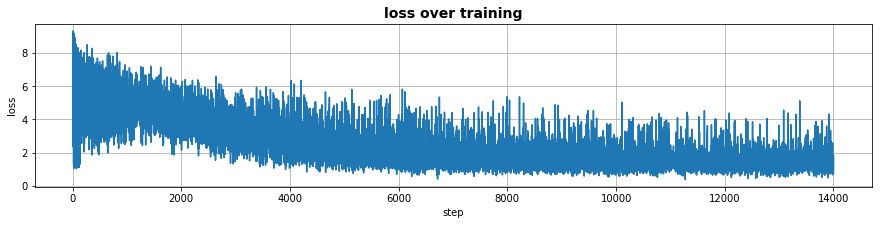

In [40]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder=encoder1,
           decoder=attn_decoder1,
           n_iters=15000,
           status_every=1000,
           pairs=training_pairs_A,
           valid_pairs=valid_pairs_A,
           encoder_path="b4_encoder1_att.pkl",
           decoder_path="b4_decoder1_att.pkl")

mean training loss = 5.25
mean valid loss = 4.32
time in 1000 steps: 2m 21s

mean training loss = 4.51
mean valid loss = 4.32
time in 1000 steps: 2m 28s

mean training loss = 3.72
mean valid loss = 3.48
time in 1000 steps: 2m 35s

mean training loss = 2.88
mean valid loss = 2.94
time in 1000 steps: 2m 43s

mean training loss = 2.37
mean valid loss = 2.35
time in 1000 steps: 2m 37s

mean training loss = 1.96
mean valid loss = 2.00
time in 1000 steps: 2m 39s

mean training loss = 1.80
mean valid loss = 2.10
time in 1000 steps: 2m 38s

mean training loss = 1.67
mean valid loss = 1.76
time in 1000 steps: 2m 37s

mean training loss = 1.59
mean valid loss = 1.61
time in 1000 steps: 2m 36s

mean training loss = 1.55
mean valid loss = 1.73
time in 1000 steps: 2m 37s

mean training loss = 1.50
mean valid loss = 1.70
time in 1000 steps: 2m 36s

mean training loss = 1.48
mean valid loss = 1.62
time in 1000 steps: 2m 37s

mean training loss = 1.45
mean valid loss = 1.63
time in 1000 steps: 2m 38s


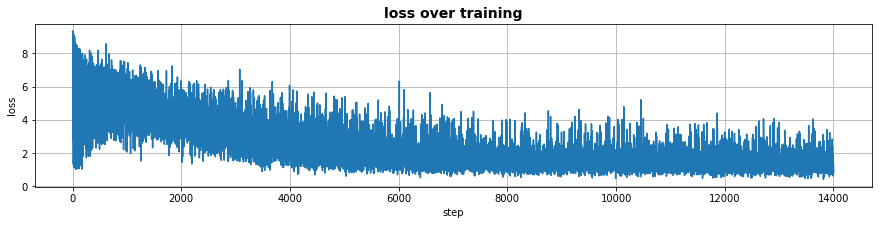

In [41]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.13).to(device)

trainIters(encoder=encoder2,
           decoder=attn_decoder2,
           n_iters=15000,
           status_every=1000,
           pairs=training_pairs_B,
           valid_pairs=valid_pairs_B,
           encoder_path="b4_encoder2_att.pkl",
           decoder_path="b4_decoder2_att.pkl")

## Evaluation functions

In [42]:
save_translation(training_pairs_A,
                 encoder1,
                 attn_decoder1,
                 MAX_LENGTH,
                 "b4_training1_att.csv")

df_results = pd.read_csv("b4_training1_att.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over training data = 0.678
mean acc over training data = 0.011


In [43]:
save_translation(valid_pairs_A,
                 encoder1,
                 attn_decoder1,
                 MAX_LENGTH,
                 "b4_valid1_att.csv")

df_results = pd.read_csv("b4_valid1_att.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over valid data = 0.674
mean acc over valid data = 0.002


In [44]:
save_translation(training_pairs_B,
                 encoder2,
                 attn_decoder2,
                 MAX_LENGTH,
                 "b4_training2_att.csv")

df_results = pd.read_csv("b4_training2_att.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over training data = 0.690
mean acc over training data = 0.018


In [45]:
save_translation(valid_pairs_B,
                 encoder2,
                 attn_decoder2,
                 MAX_LENGTH,
                 "b4_valid2_att.csv")

df_results = pd.read_csv("b4_valid2_att.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over valid data = 0.682
mean acc over valid data = 0.002


In [46]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [47]:
output_words, attentions = evaluate(encoder1,
                                    attn_decoder1,
                                    "julio paid him and fell off")

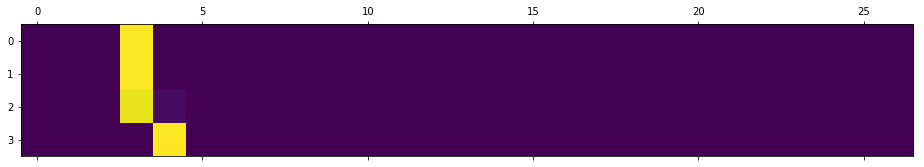

In [48]:
plt.matshow(attentions.numpy())

In [49]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


input = julio paid him and fell off
output = violet paid him <EOS>


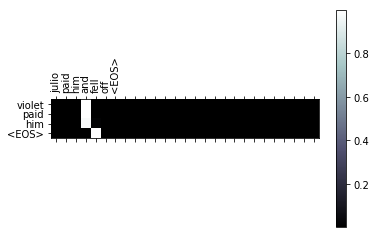

In [50]:
evaluateAndShowAttention("julio paid him and fell off")